In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from scipy import stats
from numpy import mean

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
#   using inspect in order to find out the names of columns
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Calculate the date 1 year ago from the last data point in the database

#   finding the last data point in the database
latest_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()

#   converting it to the datetime object
latest_date_obj = dt.datetime.strptime(latest_date[0], '%Y-%m-%d').date()

#   finding a date 1 year ago from last date in the dataset
year_ago = latest_date_obj - dt.timedelta(days=365)

In [14]:
# Perform a query to retrieve the data and precipitation scores

sel = [Measurements.date, Measurements.prcp]

last_12_months = session.query(*sel).\
    filter(Measurements.date >= year_ago).statement

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_data_df = pd.read_sql_query(last_12_months, session.bind)
precipitation_data_df.set_index('date', inplace=True)

In [16]:
# Sort the dataframe by date
precipitation_data_df.sort_index(inplace=True)

#  additionally - removed empty rows
precipitation_data_df = precipitation_data_df.dropna(how='any')

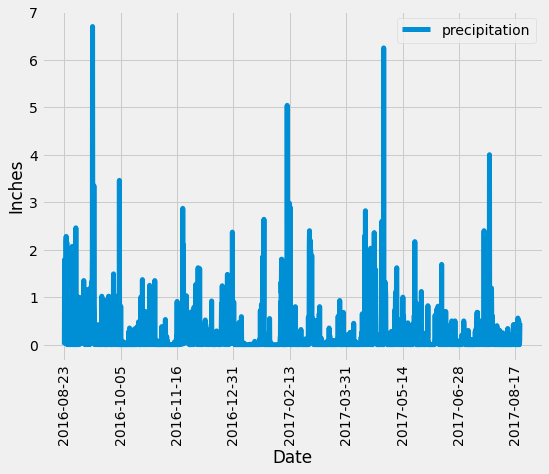

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_data_df.plot(figsize=(8,6), x_compat=True, linewidth=5, rot=90)

ax.legend(["precipitation"])

plt.xlabel("Date")
plt.ylabel("Inches")


plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?

In [20]:
#   using inspect in order to find out the names of columns
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [21]:
stations_count = session.query(Stations.name).distinct().all()
print(f'There are {len(stations_count)} stations in the station dataset.')

There are 9 stations in the station dataset.


In [22]:
stations_count_2 = session.query(Measurements.station).distinct().count()
print(f'There are {stations_count_2} stations in the measurements dataset.')

There are 9 stations in the measurements dataset.


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active_stations = session.query(Measurements.station, func.count(Measurements.station), Stations.name).\
    filter(Measurements.tobs.isnot(None)).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).\
    filter(Measurements.station == Stations.station).all()

for row in most_active_stations:
    print(row)

('USC00519281', 2772, 'WAIHEE 837.5, HI US')
('USC00519397', 2724, 'WAIKIKI 717.2, HI US')
('USC00513117', 2709, 'KANEOHE 838.1, HI US')
('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US')
('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00517948', 1372, 'PEARL CITY, HI US')
('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')


In [24]:
#   finding the most active station in the database
print(f'The most active station in the database is {most_active_stations[0][0]} - {most_active_stations[0][2]}.')

The most active station in the database is USC00519281 - WAIHEE 837.5, HI US.


In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_sel = [Measurements.station, 
       func.min(Measurements.tobs), 
       func.max(Measurements.tobs), 
       func.avg(Measurements.tobs)]

temperatures = session.query(*temp_sel).\
    filter(Measurements.station == "USC00519281").all()

#  records loaded to DataFrame for nicer display
temperatures_df = pd.DataFrame(temperatures, columns=["station ID", "lowest temperature recorded [F]", "highest temperature recorded [F]", "average temperature [F]"])
temperatures_df["average temperature [F]"] = temperatures_df["average temperature [F]"].map("{:.1f}".format)
temperatures_df

,station ID,lowest temperature recorded [F],highest temperature recorded [F],average temperature [F]
0,USC00519281,54.0,85.0,71.7


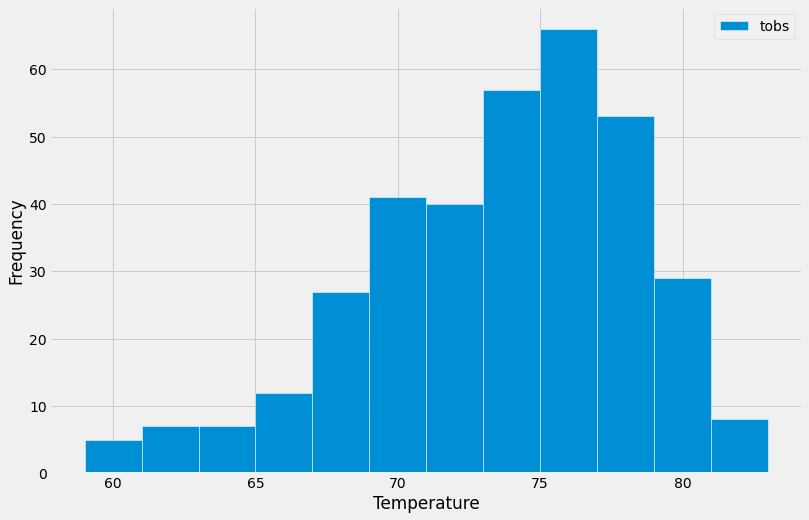

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_months_tobs = session.query(Measurements.station, Measurements.date, Measurements.tobs).filter(Measurements.station == "USC00519281").filter(Measurements.date >= year_ago).statement

last_12_months_tobs_df = pd.read_sql_query(last_12_months_tobs, session.bind)

last_12_months_tobs_df.tobs.plot.hist(bins=12, figsize=(12,8), edgecolor='white', legend=True)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

Temperature Analysis I

In [27]:
#Identify the average temperature in June at all stations across all available years in the dataset.
# Do the same for December temperature.

sel = [Measurements.date, func.avg(Measurements.tobs)]

june_averages = session.query(*sel).\
    filter(func.strftime("%m", Measurements.date) == "06").\
    group_by(func.strftime("%Y-%m", Measurements.date)).all()

december_averages = session.query(*sel).\
    filter(func.strftime("%m", Measurements.date) == "12").\
    group_by(func.strftime("%Y-%m", Measurements.date)).all()


In [28]:
# Average June temperature at all stations across all available years
june_averages_list = [result[1] for result in june_averages]
# last item in june list is removed, because dataset ends in August so there is no data for December in 2017
june_averages_list.pop()

# Average December temperature at all stations across all available years
december_averages_list = [result[1] for result in december_averages]

print(mean(june_averages_list), mean(december_averages_list))

74.6651909512669 71.10885756564662


In [29]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?

# paired t-test is being used because the temperature measurements are taken in the same spots 
# (measurements are taken on the same group)

jd_p_value = stats.ttest_rel(june_averages_list, december_averages_list)[1]

print(f'p-value of average temperature measurements in June and December is {jd_p_value}')


p-value of average temperature measurements in June and December is 0.00023742611093245777


Temperature Analysis II

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_holiday_start_date = '2017-01-27'
my_holiday_end_date = '2017-02-10'

holiday_temps = calc_temps(my_holiday_start_date, my_holiday_end_date)

print(holiday_temps)

[(59.0, 68.30927835051547, 80.0)]


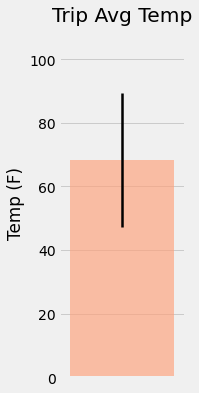

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

holiday_results_df = pd.DataFrame(holiday_temps, columns=["min", "avg", "max"])

yerr = holiday_results_df['max'] - holiday_results_df['min']

holiday_results_df.plot(kind="bar", y="avg", figsize=(2,6), legend=False, title="Trip Avg Temp", color='lightsalmon', alpha=0.65, width=2.5, yerr=yerr[0], error_kw=dict(lw=2.5))
plt.xticks([], [])
plt.ylim(0, 110)
plt.ylabel("Temp (F)")

plt.show()

Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(Measurements.station, func.sum(Measurements.prcp), Stations.name, Stations.latitude, Stations.longitude, Stations.elevation).\
    filter(Measurements.date >= my_holiday_start_date).\
    filter(Measurements.date <= my_holiday_end_date).\
    group_by(Measurements.station).\
    order_by(func.sum(Measurements.prcp).desc()).\
    filter(Measurements.station == Stations.station).\
    all()

#  records loaded to DataFrame for nicer display
total_rainfall_df = pd.DataFrame(total_rainfall, columns=["station ID", "sum prcp", "name", "latitude", "longitude", "elevation"])
total_rainfall_df

,station ID,sum prcp,name,latitude,longitude,elevation
0,USC00513117,2.48,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,USC00516128,2.37,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00519523,1.80,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00519281,1.79,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,USC00514830,0.94,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,0.69,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.05,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
my_range = pd.date_range(start=my_holiday_start_date, end=my_holiday_end_date)

# Stip off the year and save a list of %m-%d strings
dates_list = [date.strftime("%m-%d") for date in my_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list = []
for date in dates_list:
    daily_normals_list.append(daily_normals(date)[0])  

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(daily_normals_list, columns=['tmin', 'tavg', 'tmax'])
daily_normals_df["trip_dates"] = my_range
daily_normals_df.set_index('trip_dates', inplace=True)
daily_normals_df

,tmin,tavg,tmax
trip_dates,,,
2017-01-27,59.0,68.568966,75.0
2017-01-28,62.0,69.037037,77.0
2017-01-29,64.0,69.140000,76.0
2017-01-30,60.0,67.129630,77.0
2017-01-31,60.0,68.473684,74.0
2017-02-01,56.0,68.140351,78.0
2017-02-02,59.0,68.859649,77.0
2017-02-03,58.0,67.796610,77.0
2017-02-04,61.0,68.140351,76.0


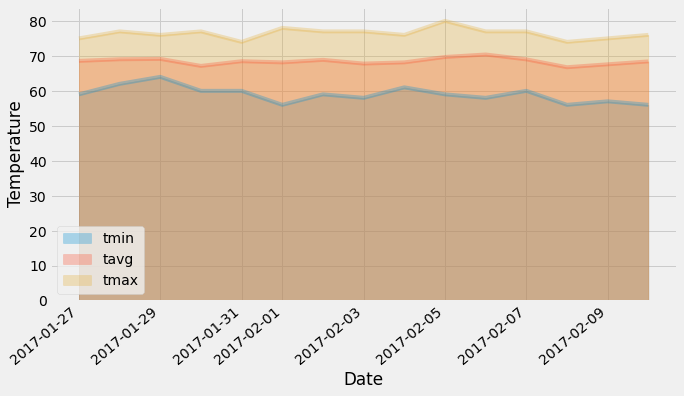

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False, figsize=(10,6), legend=True, alpha=0.3, x_compat=True, rot=40)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()